<h2 style='color:blue' align='center'>Transfer learning in image classification</h2>

**In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand**

In [ ]:
# Install tensorflow_hub using pip install tensorflow_hub first

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Make predictions using ready made model (without any training)**

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

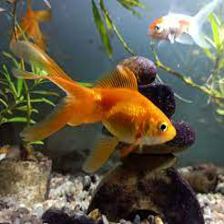

In [9]:
gold_fish = Image.open("/content/drive/MyDrive/goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [11]:
gold_fish[np.newaxis, ...]

array([[[[0.22745098, 0.28235294, 0.28235294],
         [0.23137255, 0.29019608, 0.27843137],
         [0.25882353, 0.30588235, 0.28627451],
         ...,
         [0.80392157, 0.86666667, 0.91372549],
         [0.76078431, 0.81960784, 0.89803922],
         [0.71764706, 0.77647059, 0.87843137]],

        [[0.26666667, 0.32941176, 0.32941176],
         [0.2627451 , 0.3254902 , 0.3254902 ],
         [0.27058824, 0.3254902 , 0.31764706],
         ...,
         [0.78431373, 0.84705882, 0.89019608],
         [0.74901961, 0.80784314, 0.87843137],
         [0.70980392, 0.77254902, 0.8745098 ]],

        [[0.2627451 , 0.3372549 , 0.34901961],
         [0.25098039, 0.31764706, 0.32941176],
         [0.25098039, 0.30588235, 0.31372549],
         ...,
         [0.74509804, 0.80784314, 0.84705882],
         [0.7254902 , 0.78431373, 0.85490196],
         [0.70588235, 0.76862745, 0.86666667]],

        ...,

        [[0.74901961, 0.68235294, 0.64705882],
         [0.77647059, 0.70588235, 0.67058824]

In [12]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

(1, 1001)

In [13]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

<h3 style='color:purple'>Load flowers dataset</h3>

In [15]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228818944/228813984 [==============================] - 2s 0us/step


In [16]:
data_dir

'./datasets/flower_photos'

In [17]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [18]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/daisy/2666572212_2caca8de9f_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/5586977262_6b24412805_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/8710109684_e2c5ef6aeb_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/2611119198_9d46b94392.jpg'),
 PosixPath('datasets/flower_photos/daisy/163978992_8128b49d3e_n.jpg')]

In [19]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [20]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/8063462557_e0a8bd6c64_n.jpg'),
 PosixPath('datasets/flower_photos/roses/3465443774_6b0c75a3b1_n.jpg'),
 PosixPath('datasets/flower_photos/roses/6864417932_36fa4ceecf_n.jpg'),
 PosixPath('datasets/flower_photos/roses/21522100663_455b77a90c_n.jpg'),
 PosixPath('datasets/flower_photos/roses/7683456068_02644b8382_m.jpg')]

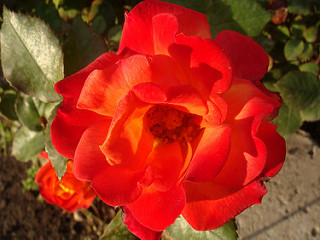

In [22]:
Image.open(str(roses[1]))

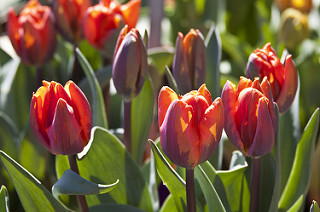

In [23]:
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[0]))

<h3 style='color:purple'>Read flowers images from disk into numpy array using opencv</h3>

In [24]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [25]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [26]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/8063462557_e0a8bd6c64_n.jpg'),
 PosixPath('datasets/flower_photos/roses/3465443774_6b0c75a3b1_n.jpg'),
 PosixPath('datasets/flower_photos/roses/6864417932_36fa4ceecf_n.jpg'),
 PosixPath('datasets/flower_photos/roses/21522100663_455b77a90c_n.jpg'),
 PosixPath('datasets/flower_photos/roses/7683456068_02644b8382_m.jpg')]

In [27]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/8063462557_e0a8bd6c64_n.jpg'

In [28]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [29]:
img.shape

(248, 320, 3)

In [30]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [31]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [32]:
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images</h3>

In [34]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Make prediction using pre-trained model on new flowers dataset**

In [35]:
X[0].shape

(224, 224, 3)

In [36]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [37]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

In [38]:
x0_resized.shape

(224, 224, 3)

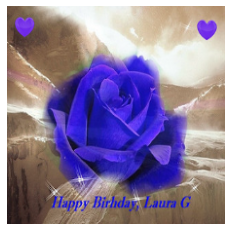

In [39]:
plt.axis('off')
plt.imshow(X[0])

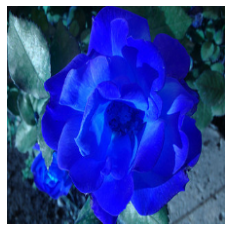

In [40]:
plt.axis('off')
plt.imshow(X[1])

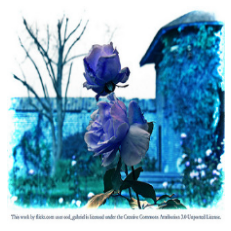

In [41]:
plt.axis('off')
plt.imshow(X[2])

In [42]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

array([795, 795, 795])

In [43]:
image_labels[795]

IndexError: ignored

<h3 style='color:purple'>Now take pre-trained model and retrain it using flowers images</h3>

In [44]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [45]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [46]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 77s 857ms/step - loss: 0.7979 - acc: 0.6951
Epoch 2/5
86/86 [==============================] - 74s 855ms/step - loss: 0.4243 - acc: 0.8477
Epoch 3/5
86/86 [==============================] - 73s 854ms/step - loss: 0.3365 - acc: 0.8855
Epoch 4/5
86/86 [==============================] - 73s 852ms/step - loss: 0.2766 - acc: 0.9124
Epoch 5/5
86/86 [==============================] - 73s 850ms/step - loss: 0.2382 - acc: 0.9291


In [47]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 25s 848ms/step - loss: 0.3575 - acc: 0.8671


[0.3575465977191925, 0.8671023845672607]